In [1]:
import math
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts



from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import evaluate_retrieval, visualize_retrieval
# ==== Config ====
MODEL_PATH = "models/maxmatch_adapter_k6_sinkhorn.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 256

LR = 0.0012
WEIGHT_DECAY = 5e-5

K_SLOTS = 6
SLOT_DROPOUT_P = 0.10

SINKHORN_ITERS = 30            # più iterazioni → P più vicino a bistocastica 'dura'
SINKHORN_TAU_START = 0.208
SINKHORN_TAU_END   = 0.06     # fine più freddo → meno frazionarietà
DETACH_ASSIGNMENT = True

SCALE_S = 0.47
DELTA_1 = 0.45
DELTA_2 = 0.61
DELTA_3 = 0.564

# LAMBDA_ISDL = 0.110
# LAMBDA_GDL  = 0.085

LAMBDA_GDL = 0.10
LAMBDA_ISDL = 0.09
LAMBDA_DIV  = 0.010   # mantiene diversità senza dominare


# --- target bassi (≈ 1/3 dei precedenti) ---
LAMBDA_ISDL_TGT = 0.03
LAMBDA_GDL_TGT  = 0.03
LAMBDA_DIV_TGT  = 0.0035  # ~0.003–0.004 è sufficiente

# --- schedule: 0 per le prime epoche, poi rampa lineare ---
REG_ZERO_EPOCHS = 4      # prime 4 epoche: niente regolarizzatori
REG_RAMP_EPOCHS = 8      # rampa lineare fino a epoch 12 (se EPOCHS>=12)


AGG_BETA = 10


def _reg_factor(epoch: int) -> float:
    """Fattore ∈[0,1] per i regolarizzatori in funzione dell'epoca (1-based)."""
    if epoch <= REG_ZERO_EPOCHS:
        return 0.0
    if epoch <= REG_ZERO_EPOCHS + REG_RAMP_EPOCHS:
        return (epoch - REG_ZERO_EPOCHS) / float(REG_RAMP_EPOCHS)
    return 1.0





# ============================================================
# 1) Head set-based: t(1024) -> S_T (K x 1536)
# ============================================================
class SetPredictionHead(nn.Module):
    """
    Converte un embedding testuale globale in K slot nello spazio visivo (1536).
    - K query vettori learnable (inizializzati nel target space).
    - Proiezione testo -> spazio visivo + gating per diversificare contributi.
    - Piccolo dropout per evitare collasso precoce.
    """
    def __init__(self, d_text=1024, d_vis=1536, K=4, hidden=2048, slot_dropout_p=0.1):
        super().__init__()
        self.K = K
        self.d_vis = d_vis

        self.text_to_vis = nn.Sequential(
            nn.Linear(d_text, hidden),
            nn.GELU(),
            nn.Linear(hidden, d_vis),
        )

        self.slot_queries = nn.Parameter(torch.randn(K, d_vis) * 0.02)
        self.gate_per_slot = nn.Linear(d_text, K)
        self.delta_per_slot = nn.Linear(d_text, K * d_vis)

        self.ln_slots = nn.LayerNorm(d_vis)
        self.ln_text  = nn.LayerNorm(d_vis)
        self.dropout = nn.Dropout(p=slot_dropout_p)

    def forward(self, t: torch.Tensor):
        B = t.size(0)
        t_vis = self.text_to_vis(t)                 # (B, d_vis)
        t_vis = self.ln_text(t_vis)

        gate  = torch.sigmoid(self.gate_per_slot(t))      # (B, K)
        delta = self.delta_per_slot(t).view(B, self.K, self.d_vis)

        Q = self.slot_queries.unsqueeze(0).expand(B, -1, -1)  # (B, K, d_vis)
        t_vis_exp = t_vis.unsqueeze(1).expand(-1, self.K, -1)
        gate_exp  = gate.unsqueeze(-1)

        # --- residui (pre-fusione globale) ---
        R = Q + gate_exp * t_vis_exp + delta               # (B, K, d_vis)
        R = self.ln_slots(R)
        R = self.dropout(R)
        E_T = F.normalize(R, dim=-1)                       # residui normalizzati (per ISDL)

        # --- fusione globale per scoring ---
        S_T = E_T + F.normalize(t_vis, dim=-1).unsqueeze(1)
        S_T = F.normalize(S_T, dim=-1)
        return S_T, E_T, F.normalize(t_vis, dim=-1)
# ============================================================
# 2) Sinkhorn matching (soft, entropic-regularized doubly-stochastic)
#    sim -> P ~ doubly-stochastic, poi S_H = <P, sim>/K
# ============================================================
def sinkhorn_logspace(log_K: torch.Tensor, iters: int = 10) -> torch.Tensor:
    """
    Log-space Sinkhorn per stabilità numerica.
    log_K: (B, K, K) log-kernel (logits pre-softmax)
    Ritorna log_P: (B, K, K) ~ log matrix bistocastica
    """
    B, K, _ = log_K.shape
    log_u = torch.zeros(B, K, device=log_K.device)
    log_v = torch.zeros(B, K, device=log_K.device)

    for _ in range(iters):
        # normalizza righe
        log_u = -torch.logsumexp(log_K + log_v.unsqueeze(1), dim=2)
        # normalizza colonne
        log_v = -torch.logsumexp(log_K + log_u.unsqueeze(2), dim=1)

    log_P = log_K + log_u.unsqueeze(2) + log_v.unsqueeze(1)
    return log_P

def sinkhorn_assignment(sim: torch.Tensor, tau: float = 0.1, iters: int = 10,
                        detach_input: bool = True) -> torch.Tensor:
    """
    sim: (B, K, K) similarità coseno.
    Costruisce kernel K_ij = exp(sim_ij / tau), applica Sinkhorn per ottenere P ~ bistocastica.
    Se detach_input=True, rimuove il gradiente dalla matrice di sim nel calcolo dell'assegnamento,
    replicando lo schema "stop-grad" usato in MaxMatch per la parte di matching.
    """
    if detach_input:
        sim = sim.detach()
    log_K = sim / max(tau, 1e-6)
    log_P = sinkhorn_logspace(log_K, iters=iters)
    P = torch.exp(log_P)  # (B, K, K), righe/colonne ~ 1
    return P

def cosine_matrix(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    # (B, K, D) x (B, D, K) -> (B, K, K)
    return torch.matmul(A, B.transpose(-1, -2))

def s_h_maxmatch_sinkhorn(
    S_T: torch.Tensor, V: torch.Tensor, *,
    tau: float, iters: int, detach: bool
) -> torch.Tensor:
    B, K, D = S_T.shape
    Vn = F.normalize(V, dim=-1)
    S_V = Vn.unsqueeze(1).expand(-1, K, -1)        # (B, K, D)
    sims = torch.matmul(S_T, S_V.transpose(-1, -2))# (B, K, K)
    P = sinkhorn_assignment(sims, tau=tau, iters=iters, detach_input=detach)
    return (P * sims).sum(dim=(1, 2)) / K

def s_h(S_T: torch.Tensor, V: torch.Tensor, *, tau, iters, detach) -> torch.Tensor:
    return s_h_maxmatch_sinkhorn(S_T, V, tau=tau, iters=iters, detach=detach)



@torch.no_grad()
def ent_rowsoftmax_diagnostics(S_T, V, tau, sharp=0.25, sim_scale=5.0):
    Vn = F.normalize(V, dim=-1)
    sims = torch.matmul(S_T, Vn.transpose(0,1))       # (B,K,B)
    tau_eff = max(1e-6, tau * sharp)
    Q = torch.softmax(sims * (sim_scale / tau_eff), dim=2)
    row_max = Q.max(dim=2).values.mean().item()       # picco medio per riga
    H_rows  = (-(Q.add(1e-12) * Q.add(1e-12).log()).sum(dim=2)).mean().item()
    return row_max, H_rows

     


def triplet_vectors_hardest(Z: torch.Tensor, Y: torch.Tensor, margin: float) -> torch.Tensor:
    """
    Z: (B,D) pred text→vis (L2)
    Y: (B,D) gt image embeddings (L2)
    margin: DELTA_1
    """
    S = Z @ Y.t()                               # (B,B) cosine sim
    pos = S.diag()                              # (B,)
    B = Z.size(0)
    S = S.clone()
    S[torch.arange(B), torch.arange(B)] = float('-inf')
    neg = S.max(dim=1).values                   # hardest neg per riga
    return F.relu(margin + neg - pos).mean()


# ============================================================
# 3) ISDL – Intra-Set Diversity Loss (Alomari 2025)
#     Minimizza similarità intra-slot (promuove diversità)
# ============================================================
def isdl_intra_set_diversity_exp(S_T: torch.Tensor, s: float, delta3: float) -> torch.Tensor:
    B, K, D = S_T.shape
    C = torch.matmul(S_T, S_T.transpose(-1, -2)).clamp(-1, 1)  # (B,K,K)
    mask = ~torch.eye(K, device=S_T.device, dtype=torch.bool).unsqueeze(0).expand(B, K, K)
    C_off = C[mask]  # (B*K*(K-1),)
    loss = torch.exp(s * (C_off - delta3)).mean()
    return loss

import random, numpy as np, torch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ===========================
# 0) Seed e backend (come sopra)
# ===========================
import random, numpy as np, torch
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ===========================
# 1) Caricamento dati (caption/image embeddings)
# ===========================
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)   # X: (N_cap, D_txt)  | y: (N_cap, D_img)

# ===========================
# 2) Split a LIVELLO IMMAGINE (prima del training)
# ===========================
import hashlib
from scipy import sparse

img_names_all = train_data['images/names']                                 # (N_img,)
img_emb_all   = torch.from_numpy(train_data['images/embeddings']).float()  # (N_img, D_img)

val_ratio = 0.10
def stable_hash(name: str) -> float:
    h = hashlib.md5(name.encode('utf-8')).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF

img_hash       = np.array([stable_hash(nm) for nm in img_names_all])
IMG_VAL_MASK   = (img_hash < val_ratio)           # np.bool_
IMG_TRAIN_MASK = ~IMG_VAL_MASK

# Mappa caption → indice globale dell'immagine GT
cap_to_img = train_data['captions/label']
if sparse.issparse(cap_to_img):
    cap_gt_img_idx = cap_to_img.argmax(axis=1).A1
else:
    cap_gt_img_idx = np.argmax(cap_to_img, axis=1)

# Maschere caption coerenti con lo split immagine
CAP_TRAIN_MASK = IMG_TRAIN_MASK[cap_gt_img_idx]   # np.bool_
CAP_VAL_MASK   = IMG_VAL_MASK[cap_gt_img_idx]     # np.bool_

# Sanity: nessuna immagine in comune tra train e val
overlap_imgs = (IMG_TRAIN_MASK & IMG_VAL_MASK).any()
assert not overlap_imgs, f"Overlap immagini train/val > 0"

# ===========================
# 3) Costruisci tensori train/val
# ===========================
X_train = X[CAP_TRAIN_MASK]
y_train = y[CAP_TRAIN_MASK]
X_val   = X[CAP_VAL_MASK]
y_val   = y[CAP_VAL_MASK]

print(f"Train captions: {len(X_train):,} | Val captions: {len(X_val):,}")
print(f"Train images  : {int(IMG_TRAIN_MASK.sum()):,} | Val images  : {int(IMG_VAL_MASK.sum()):,}")

# ===========================
# 4) DataLoader
# ===========================
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=(DEVICE.type=='cuda'))
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=(DEVICE.type=='cuda'))

# ===========================
# 5) Istanziazione modello
# ===========================
model = SetPredictionHead(
    d_text=X.shape[1],
    d_vis=y.shape[1],
    K=K_SLOTS,
    hidden=2048,
    slot_dropout_p=SLOT_DROPOUT_P
).to(DEVICE)

# ---- Aggregatore unico train/test: softmax_b10 ----
def aggregate_slots_softmax(S_T: torch.Tensor, t_vis_n: torch.Tensor, beta: float = 10.0) -> torch.Tensor:
    """
    S_T: (B,K,D) slots già L2-normalizzati
    t_vis_n: (B,D) globale testo L2-normalizzato
    Ritorna: Z (B,D) L2-normalizzato
    """
    # conf_k = cos(S_k, t_vis)
    conf = torch.einsum('bkd,bd->bk', S_T, t_vis_n).clamp(-1, 1)   # (B,K)
    w = torch.softmax(beta * conf, dim=1).unsqueeze(-1)            # (B,K,1)
    Z = (w * S_T).sum(dim=1)                                       # (B,D)
    return F.normalize(Z, dim=-1)




print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n[Train] MaxMatch + Sinkhorn + ISDL + GDL (curriculum su τ) ...")

# ============================================================
# 4) GDL – Global Discriminative Loss (Alomari 2025)
#  
# ============================================================
def gdl_global_discriminative_true(E_Tn, t_vis_norm, s: float, delta2: float):
    """
    GDL sui residui normalizzati (pre-fusione), per evitare che gli slot collassino sul globale.
    """
    sims = torch.einsum('bkd,bd->bk', E_Tn, t_vis_norm).clamp(-1,1)
    return torch.exp(s * (sims - delta2)).mean()



# ============================================================
# 5) Diagnostica
# ============================================================



@torch.no_grad()
def quick_margin_on_val_batch(model, val_dataset, device, tau, iters, detach=True, batch=512):
    loader = DataLoader(val_dataset, batch_size=min(batch, len(val_dataset)), shuffle=True)
    Xb, Yb = next(iter(loader))
    Xb, Yb = Xb.to(device), Yb.to(device)

    # forward
    S_T, _, _ = model(Xb)                          # (B,K,D)
    B, K, D = S_T.shape
    V_all = F.normalize(Yb, dim=-1)                # (B,D)

    # s_pos
    s_pos = s_h(S_T, Yb, tau=tau, iters=iters, detach=detach)  # (B,)

    # s_neg (hardest in-batch)
    CH = 256
    max_negs = []
    for start in range(0, B, CH):
        end = min(B, start + CH)
        S_blk = S_T[start:end]                                     # (ch,K,D)
        S_exp = S_blk.unsqueeze(1).expand(end-start, B, K, D).reshape((end-start)*B, K, D)
        V_exp = V_all.unsqueeze(0).expand(end-start, B, D).reshape((end-start)*B, D)
        s_blk = s_h(S_exp, V_exp, tau=tau, iters=iters, detach=detach).view(end-start, B)
        rows = torch.arange(end-start, device=device)
        cols = torch.arange(start, end,   device=device)
        s_blk[rows, cols] = float('-inf')                           # maschera il positivo
        max_negs.append(s_blk.max(dim=1).values)
    s_neg = torch.cat(max_negs, dim=0)                              # (B,)

    margin = (s_pos - s_neg).mean().item()
    return margin, s_pos.mean().item(), s_neg.mean().item()



@torch.no_grad()
def slot_log_variance(S_T: torch.Tensor) -> float:
    var_fd = S_T.var(dim=1, unbiased=False)   # (B, D)
    var_mean = var_fd.mean(dim=1).mean().clamp_min(1e-8)
    return float(torch.log(var_mean).item())


@torch.no_grad()
def mean_offdiag_cos(E_Tn):
    K = E_Tn.size(1)
    C = torch.matmul(E_Tn, E_Tn.transpose(-1,-2))          # (B,K,K)
    off = C - torch.eye(K, device=E_Tn.device).unsqueeze(0)
    denom = max(K*(K-1), 1)
    return float(off.abs().sum(dim=(1,2)).mean().item() / denom)



def diversity_regularizer_exp(E: torch.Tensor, s: float = 1.0):
    """
    Accetta:
      - E: (B,K,D)  -> viene flattenato a (B*K, D)
      - E: (N,D)    -> usato così com'è
    """
    if E.dim() == 3:
        B, K, D = E.shape
        E = E.reshape(B * K, D)
    elif E.dim() == 2:
        D = E.size(1)
    else:
        raise ValueError(f"diversity_regularizer_exp: atteso 2D/3D, trovato {tuple(E.shape)}")

    C = (E @ E.t()).clamp(-1, 1)  # (N,N)
    mask = ~torch.eye(E.size(0), device=E.device, dtype=torch.bool)
    C_off = C[mask]
    return torch.exp(-2.0 * (1 - C_off)).mean()


def subsample_rows(X: torch.Tensor, max_n: int):
    n = X.size(0)
    if n <= max_n: return X
    idx = torch.randint(0, n, (max_n,), device=X.device)
    return X.index_select(0, idx)

# Subsample per evitare O(n^2) pieno
RES_MAX = 512      # righe per DIV (BK ~ B*K)
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int,
                lr: float,
                logvar_warm_epochs: int = 3) -> nn.Module:

    opt = torch.optim.AdamW(model.parameters(), lr=1.2e-3, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=1.8e-3, total_steps=len(train_loader)*EPOCHS,
        pct_start=0.15, anneal_strategy="cos", div_factor=10.0, final_div_factor=100.0
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    for epoch in range(1, epochs + 1):
        model.train()
        logvar_vals, offdiag_vals = [], []
        frac = (epoch - 1) / max(epochs - 1, 1)
        SINKHORN_TAU = SINKHORN_TAU_START + frac * (SINKHORN_TAU_END - SINKHORN_TAU_START)
        SINKHORN_TAU = max(SINKHORN_TAU_END, SINKHORN_TAU)  # floor = *_END

        for Xb, Yb in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{epochs}"):


            Xb = Xb.to(device, non_blocking=True)
            Yb = Yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                # --- forward ---
                S_T, E_T, t_vis_n = model(Xb)      # S_T: scoring; E_T: residui (ISDL); t_vis_n: globale normalizzato
                E_Tn = F.normalize(E_T, dim=-1)

                # --- diagnostica ---
                if epoch <= logvar_warm_epochs:
                    logvar_vals.append(slot_log_variance(S_T))
                offdiag_vals.append(mean_offdiag_cos(E_Tn))

                # --- vettore finale Z con lo stesso aggregatore della submission ---
                Zb = aggregate_slots_softmax(S_T, t_vis_n, beta=AGG_BETA)   # (B,D)

                # --- loss principale: triplet su Z ---
                Yb_n = F.normalize(Yb, dim=-1)
                loss_tri = triplet_vectors_hardest(Zb, Yb_n, margin=DELTA_1)

                # 2) ISDL (intra-set, exp con margine)
                loss_isdl = isdl_intra_set_diversity_exp(E_Tn, s=SCALE_S, delta3=DELTA_3
                )

                # 3) GDL (slot vs globale t_vis nello stesso spazio)
                loss_gdl = gdl_global_discriminative_true(
                    E_Tn, t_vis_n, s=SCALE_S, delta2=DELTA_2
                )

                E_flat_ss = subsample_rows(E_Tn.reshape(-1, E_Tn.size(-1)), RES_MAX)
                loss_div  = diversity_regularizer_exp(E_flat_ss, s=1.0)
                
                reg_f = _reg_factor(epoch)
                lam_isdl = LAMBDA_ISDL_TGT * reg_f
                lam_gdl  = LAMBDA_GDL_TGT  * reg_f
                lam_div  = LAMBDA_DIV_TGT  * reg_f

                loss = (loss_tri
                        + lam_isdl * loss_isdl
                        + lam_gdl  * loss_gdl
                        + lam_div  * loss_div)

            # --- backward + step (AMP) ---
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()
            sched.step()

        #Versione rapidissima (1 batch di val)    
        if epoch == 4:
            margin, spos_m, sneg_m = quick_margin_on_val_batch(
                model, val_dataset, DEVICE,
                tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=True, batch=512
            )
            print(f"[Val-quick] margin={margin:.4f} | s_pos={spos_m:.4f} | s_neg*={sneg_m:.4f}")


        # ===== Validation: proxy coerente con la submission (cos(Z, Y)) =====
        model.eval()
        val_cos_sum, val_batches = 0.0, 0
        with torch.no_grad():
            for Xb, Yb in DataLoader(val_loader.dataset, batch_size=BATCH_SIZE, shuffle=False):
                Xb = Xb.to(device, non_blocking=True)
                Yb = Yb.to(device, non_blocking=True)
                S_T, _, t_vis_n = model(Xb)
                Zb = aggregate_slots_softmax(S_T, t_vis_n, beta=AGG_BETA)
                Yb_n = F.normalize(Yb, dim=-1)
                cos_b = torch.einsum('bd,bd->b', Zb, Yb_n).mean()   # media del coseno batch
                val_cos_sum += float(cos_b.item())
                val_batches += 1

        val_score = val_cos_sum / max(val_batches, 1)

        logvar_text = ""
        if len(logvar_vals) > 0:
            logvar_epoch = sum(logvar_vals) / len(logvar_vals)
            logvar_text = f" | log-var(S_T): {logvar_epoch:.2f}"

        print(f"val z_cos={val_score:.4f} | loss_tri={float(loss_tri.item()):.4f} \n"
            f"| isdl={float(loss_isdl.item()):.4f} | gdl={float(loss_gdl.item()):.4f} \n"
            f"| last_loss={float(loss.item()):.4f} | offdiag(E_T): {sum(offdiag_vals)/len(offdiag_vals):.4f}{logvar_text}|\n")
        print(f"[reg] epoch={epoch} factor={reg_f:.2f} | λ_isdl={lam_isdl:.4f} λ_gdl={lam_gdl:.4f} λ_div={lam_div:.4f}\n\n")
        # --- salva anche checkpoint per epoca ---
        ckpt_dir = Path(MODEL_PATH).parent / "checkpoints"
        ckpt_dir.mkdir(parents=True, exist_ok=True)
        ckpt_path = ckpt_dir / f"epoch_{epoch:03d}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ☐ Saved {ckpt_path.name}")
    return model


# ===========================
# 6) Training
# ===========================
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

(125000,)
Train data: 125000 captions, 125000 images
Train captions: 112,420 | Val captions: 12,580
Train images  : 22,484 | Val images  : 2,516
Parameters: 14,714,374

[Train] MaxMatch + Sinkhorn + ISDL + GDL (curriculum su τ) ...


[Train] Epoch 1/20:   0%|          | 0/440 [00:00<?, ?it/s]c:\Users\lucam\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
[Train] Epoch 1/20: 100%|██████████| 440/440 [00:09<00:00, 47.52it/s]


val z_cos=0.2253 | loss_tri=0.3787 
| isdl=0.9571 | gdl=0.9690 
| last_loss=0.3787 | offdiag(E_T): 0.4376 | log-var(S_T): -9.24|

[reg] epoch=1 factor=0.00 | λ_isdl=0.0000 λ_gdl=0.0000 λ_div=0.0000


  ☐ Saved epoch_001.pth


[Train] Epoch 2/20: 100%|██████████| 440/440 [00:11<00:00, 38.42it/s]


val z_cos=0.2558 | loss_tri=0.3735 
| isdl=0.9921 | gdl=0.9363 
| last_loss=0.3735 | offdiag(E_T): 0.5178 | log-var(S_T): -9.34|

[reg] epoch=2 factor=0.00 | λ_isdl=0.0000 λ_gdl=0.0000 λ_div=0.0000


  ☐ Saved epoch_002.pth


[Train] Epoch 3/20: 100%|██████████| 440/440 [00:11<00:00, 39.45it/s]


val z_cos=0.2658 | loss_tri=0.3733 
| isdl=0.9553 | gdl=0.8815 
| last_loss=0.3733 | offdiag(E_T): 0.5071 | log-var(S_T): -9.25|

[reg] epoch=3 factor=0.00 | λ_isdl=0.0000 λ_gdl=0.0000 λ_div=0.0000


  ☐ Saved epoch_003.pth


[Train] Epoch 4/20: 100%|██████████| 440/440 [00:09<00:00, 46.71it/s]


[Val-quick] margin=0.0037 | s_pos=0.2330 | s_neg*=0.2293
val z_cos=0.2655 | loss_tri=0.3298 
| isdl=0.9196 | gdl=0.8596 
| last_loss=0.3298 | offdiag(E_T): 0.4173|

[reg] epoch=4 factor=0.00 | λ_isdl=0.0000 λ_gdl=0.0000 λ_div=0.0000


  ☐ Saved epoch_004.pth


[Train] Epoch 5/20: 100%|██████████| 440/440 [00:09<00:00, 46.14it/s]


val z_cos=0.2593 | loss_tri=0.3225 
| isdl=0.8428 | gdl=0.8174 
| last_loss=0.3288 | offdiag(E_T): 0.2649|

[reg] epoch=5 factor=0.12 | λ_isdl=0.0037 λ_gdl=0.0037 λ_div=0.0004


  ☐ Saved epoch_005.pth


[Train] Epoch 6/20: 100%|██████████| 440/440 [00:09<00:00, 45.22it/s]


val z_cos=0.2529 | loss_tri=0.3218 
| isdl=0.8070 | gdl=0.7846 
| last_loss=0.3338 | offdiag(E_T): 0.1348|

[reg] epoch=6 factor=0.25 | λ_isdl=0.0075 λ_gdl=0.0075 λ_div=0.0009


  ☐ Saved epoch_006.pth


[Train] Epoch 7/20: 100%|██████████| 440/440 [00:09<00:00, 45.55it/s]


val z_cos=0.2632 | loss_tri=0.3186 
| isdl=0.7815 | gdl=0.7720 
| last_loss=0.3363 | offdiag(E_T): 0.0802|

[reg] epoch=7 factor=0.38 | λ_isdl=0.0112 λ_gdl=0.0112 λ_div=0.0013


  ☐ Saved epoch_007.pth


[Train] Epoch 8/20: 100%|██████████| 440/440 [00:09<00:00, 44.98it/s]


val z_cos=0.2612 | loss_tri=0.3201 
| isdl=0.7682 | gdl=0.7647 
| last_loss=0.3433 | offdiag(E_T): 0.0752|

[reg] epoch=8 factor=0.50 | λ_isdl=0.0150 λ_gdl=0.0150 λ_div=0.0018


  ☐ Saved epoch_008.pth


[Train] Epoch 9/20: 100%|██████████| 440/440 [00:10<00:00, 43.65it/s]


val z_cos=0.2599 | loss_tri=0.3044 
| isdl=0.7608 | gdl=0.7521 
| last_loss=0.3331 | offdiag(E_T): 0.0699|

[reg] epoch=9 factor=0.62 | λ_isdl=0.0187 λ_gdl=0.0187 λ_div=0.0022


  ☐ Saved epoch_009.pth


[Train] Epoch 10/20: 100%|██████████| 440/440 [00:10<00:00, 41.83it/s]


val z_cos=0.2604 | loss_tri=0.3042 
| isdl=0.7571 | gdl=0.7440 
| last_loss=0.3384 | offdiag(E_T): 0.0655|

[reg] epoch=10 factor=0.75 | λ_isdl=0.0225 λ_gdl=0.0225 λ_div=0.0026


  ☐ Saved epoch_010.pth


[Train] Epoch 11/20: 100%|██████████| 440/440 [00:10<00:00, 43.24it/s]


val z_cos=0.2519 | loss_tri=0.3035 
| isdl=0.7525 | gdl=0.7385 
| last_loss=0.3431 | offdiag(E_T): 0.0628|

[reg] epoch=11 factor=0.88 | λ_isdl=0.0262 λ_gdl=0.0262 λ_div=0.0031


  ☐ Saved epoch_011.pth


[Train] Epoch 12/20: 100%|██████████| 440/440 [00:10<00:00, 42.21it/s]


val z_cos=0.2580 | loss_tri=0.3018 
| isdl=0.7498 | gdl=0.7362 
| last_loss=0.3468 | offdiag(E_T): 0.0614|

[reg] epoch=12 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_012.pth


[Train] Epoch 13/20: 100%|██████████| 440/440 [00:10<00:00, 42.72it/s]


val z_cos=0.2549 | loss_tri=0.3054 
| isdl=0.7528 | gdl=0.7313 
| last_loss=0.3505 | offdiag(E_T): 0.0606|

[reg] epoch=13 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_013.pth


[Train] Epoch 14/20: 100%|██████████| 440/440 [00:09<00:00, 45.35it/s]


val z_cos=0.2548 | loss_tri=0.2812 
| isdl=0.7516 | gdl=0.7307 
| last_loss=0.3262 | offdiag(E_T): 0.0597|

[reg] epoch=14 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_014.pth


[Train] Epoch 15/20: 100%|██████████| 440/440 [00:09<00:00, 44.45it/s]


val z_cos=0.2508 | loss_tri=0.2605 
| isdl=0.7517 | gdl=0.7300 
| last_loss=0.3055 | offdiag(E_T): 0.0590|

[reg] epoch=15 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_015.pth


[Train] Epoch 16/20: 100%|██████████| 440/440 [00:10<00:00, 43.51it/s]


val z_cos=0.2483 | loss_tri=0.2620 
| isdl=0.7554 | gdl=0.7202 
| last_loss=0.3067 | offdiag(E_T): 0.0585|

[reg] epoch=16 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_016.pth


[Train] Epoch 17/20: 100%|██████████| 440/440 [00:10<00:00, 42.21it/s]


val z_cos=0.2463 | loss_tri=0.2742 
| isdl=0.7531 | gdl=0.7250 
| last_loss=0.3190 | offdiag(E_T): 0.0578|

[reg] epoch=17 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_017.pth


[Train] Epoch 18/20: 100%|██████████| 440/440 [00:10<00:00, 43.85it/s]


val z_cos=0.2473 | loss_tri=0.2485 
| isdl=0.7541 | gdl=0.7236 
| last_loss=0.2934 | offdiag(E_T): 0.0575|

[reg] epoch=18 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_018.pth


[Train] Epoch 19/20: 100%|██████████| 440/440 [00:10<00:00, 40.56it/s]


val z_cos=0.2471 | loss_tri=0.2629 
| isdl=0.7543 | gdl=0.7163 
| last_loss=0.3076 | offdiag(E_T): 0.0572|

[reg] epoch=19 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_019.pth


[Train] Epoch 20/20: 100%|██████████| 440/440 [00:10<00:00, 43.41it/s]


val z_cos=0.2468 | loss_tri=0.2372 
| isdl=0.7526 | gdl=0.7202 
| last_loss=0.2819 | offdiag(E_T): 0.0572|

[reg] epoch=20 factor=1.00 | λ_isdl=0.0300 λ_gdl=0.0300 λ_div=0.0035


  ☐ Saved epoch_020.pth


[Eval] Val captions: 12,580 | Val images: 2,516
epoch_001.pth   → MRR=0.42703
epoch_002.pth   → MRR=0.43644
epoch_003.pth   → MRR=0.45070
epoch_004.pth   → MRR=0.45322
epoch_005.pth   → MRR=0.45636
epoch_006.pth   → MRR=0.44694
epoch_007.pth   → MRR=0.45045
epoch_008.pth   → MRR=0.44203
epoch_009.pth   → MRR=0.44634
epoch_010.pth   → MRR=0.44162
epoch_011.pth   → MRR=0.43591
epoch_012.pth   → MRR=0.43878
epoch_013.pth   → MRR=0.43275
epoch_014.pth   → MRR=0.43305
epoch_015.pth   → MRR=0.42956
epoch_016.pth   → MRR=0.42801
epoch_017.pth   → MRR=0.42843
epoch_018.pth   → MRR=0.42721
epoch_019.pth   → MRR=0.42723
epoch_020.pth   → MRR=0.42679

=== Miglior checkpoint (MRR su val-gallery) ===
epoch_005.pth → MRR=0.45636

=== Val (image-level split, global gallery) — BEST CKPT ===
mrr            : 0.4564
ndcg           : 0.5627
recall_at_1    : 0.3169
recall_at_3    : 0.5273
recall_at_5    : 0.6234
recall_at_10   : 0.7424
recall_at_50   : 0.9134
l2_dist        : 1.2154


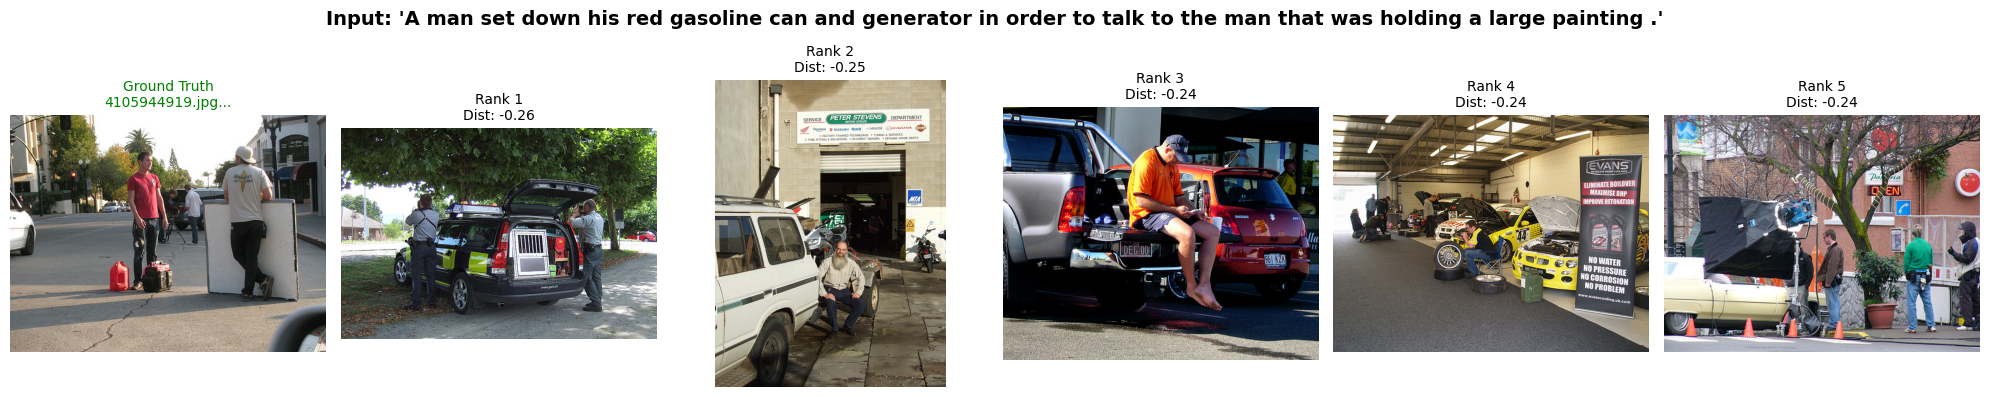

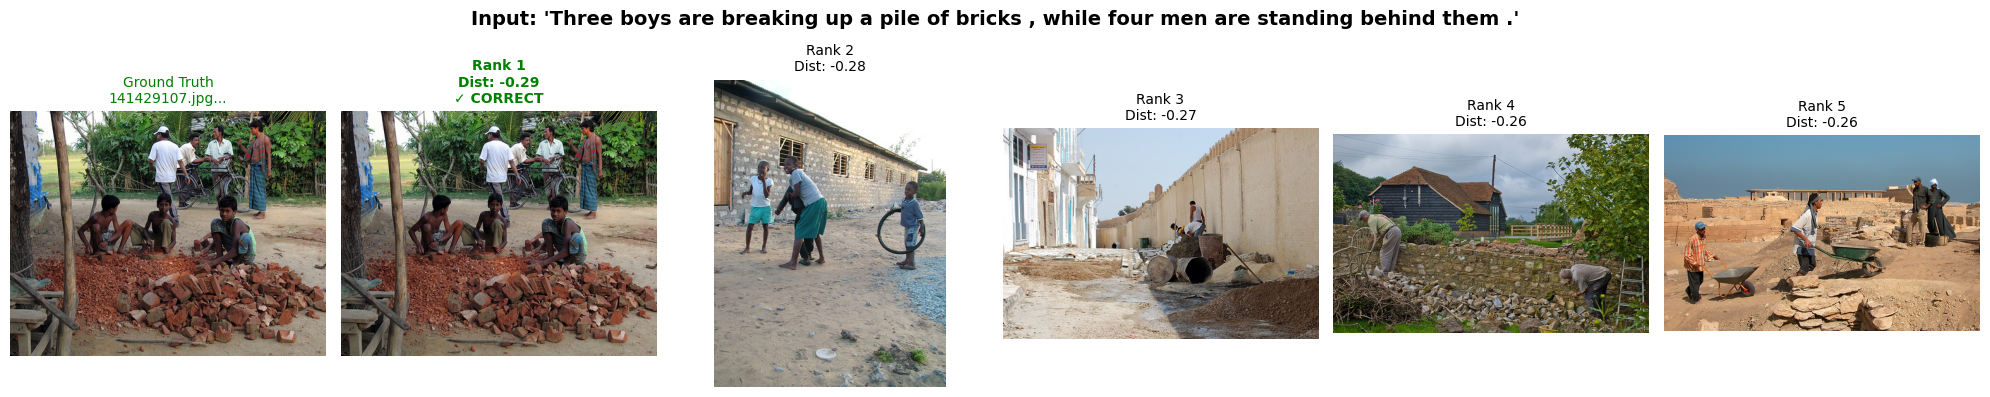

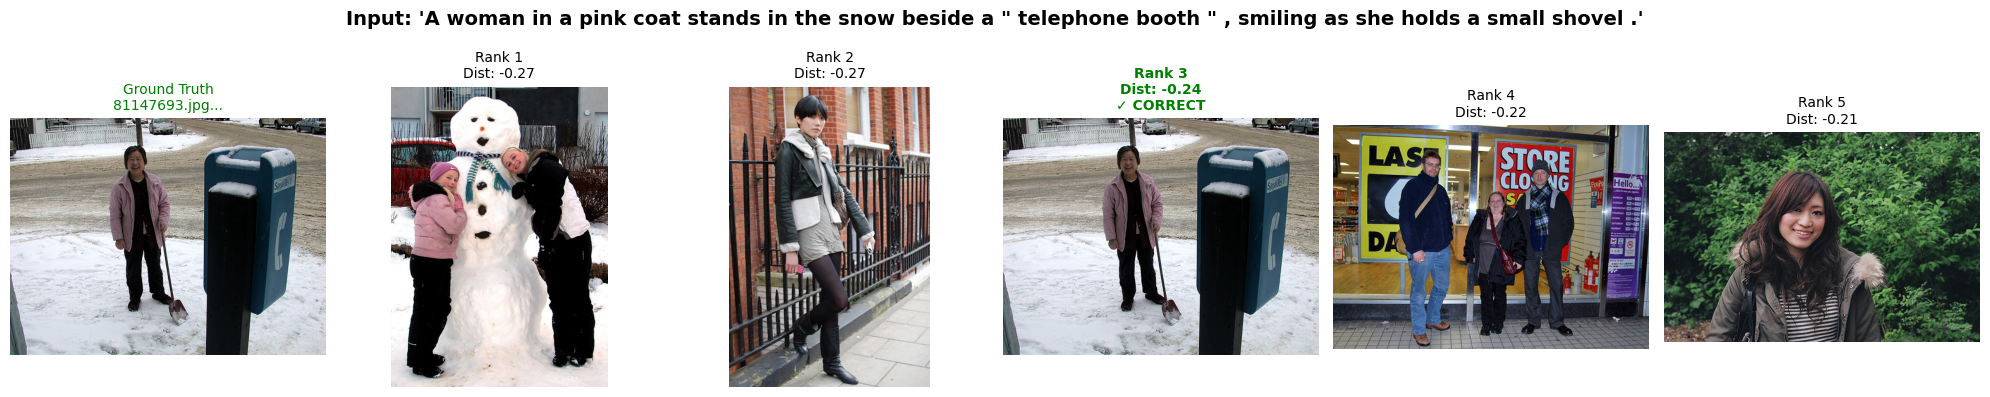


[Ready] BEST_CHECKPOINT_FOR_SUBMIT = epoch_005.pth


In [2]:
# ===========================
# Valutazione: seleziona il best checkpoint per MRR (val gallery)
# ===========================
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from challenge.src.eval.metrics import mrr, ndcg, recall_at_k  # intoccabili

model.eval()

# ============================================================
# Aggregazione slot -> 1 embedding (submission-compatibile)
# ============================================================


@torch.no_grad()
def aggregate_slots(S_T: torch.Tensor, t_vis_n: torch.Tensor) -> torch.Tensor:
    # stesso aggregatore della fase di training: softmax_b10
    conf = torch.einsum('bkd,bd->bk', S_T, t_vis_n).clamp(-1, 1)
    w = torch.softmax(10.0 * conf, dim=1).unsqueeze(-1)
    Z = (w * S_T).sum(dim=1)
    return F.normalize(Z, dim=-1)

# ===========================
# Split COERENTE per IMMAGINI (stesso hashing del train)
# ===========================
import hashlib
from scipy import sparse

img_names_all = train_data['images/names']                                  # (N_img,)
img_emb_all   = torch.from_numpy(train_data['images/embeddings']).float()   # (N_img, D_img)

val_ratio = 0.10
def stable_hash(name: str) -> float:
    h = hashlib.md5(name.encode('utf-8')).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF

img_hash       = np.array([stable_hash(nm) for nm in img_names_all])
IMG_VAL_MASK   = (img_hash < val_ratio)
IMG_TRAIN_MASK = ~IMG_VAL_MASK
assert not (IMG_VAL_MASK & IMG_TRAIN_MASK).any(), "Overlap immagini train/val > 0"

# Caption → indice globale immagine GT
cap_to_img = train_data['captions/label']
if sparse.issparse(cap_to_img):
    cap_gt_img_idx = cap_to_img.argmax(axis=1).A1
else:
    cap_gt_img_idx = np.argmax(cap_to_img, axis=1)

CAP_TRAIN_MASK = IMG_TRAIN_MASK[cap_gt_img_idx]
CAP_VAL_MASK   = IMG_VAL_MASK[cap_gt_img_idx]

# Tensors val (caption→embedding, image target embedding)
X_val = X[CAP_VAL_MASK]
y_val = y[CAP_VAL_MASK]
val_dataset = TensorDataset(X_val, y_val)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=(DEVICE.type=='cuda'))

print(f"[Eval] Val captions: {len(X_val):,} | Val images: {int(IMG_VAL_MASK.sum()):,}")

# Gallery VALIDAZIONE (solo immagini di val, normalizzate)
val_img_embd = F.normalize(img_emb_all[torch.from_numpy(IMG_VAL_MASK)], dim=-1).cpu()  # (N_img_val, D)
val_img_file = img_names_all[IMG_VAL_MASK]

# Rimappa GT caption→indice compatto della gallery val
global_to_val = -np.ones(len(img_names_all), dtype=np.int64)
global_to_val[np.where(IMG_VAL_MASK)[0]] = np.arange(IMG_VAL_MASK.sum(), dtype=np.int64)
val_gt_global = cap_gt_img_idx[CAP_VAL_MASK]
val_label = global_to_val[val_gt_global]   # (Nq,)

# ============================================================
# Helper: calcolo metriche retrieval su gallery completa
# ============================================================
@torch.no_grad()
def evaluate_retrieval_global(Z: torch.Tensor,
                              gallery: torch.Tensor,
                              gt_indices: np.ndarray,
                              topk: int = 100,
                              chunk: int = 512):
    Z = Z.to('cpu'); gallery = gallery.to('cpu')
    Nq, Ng = Z.size(0), gallery.size(0)
    topk = min(topk, Ng)

    all_topk = []
    for start in range(0, Nq, chunk):
        end = min(start + chunk, Nq)
        sims = Z[start:end] @ gallery.T
        topk_idx = torch.topk(sims, k=topk, dim=1, largest=True, sorted=True).indices
        all_topk.append(topk_idx.cpu().numpy())
    pred_indices = np.vstack(all_topk).astype(np.int64)

    l2_dist = (Z - gallery[torch.from_numpy(gt_indices)]).norm(dim=1).mean().item()
    return {
        'mrr': mrr(pred_indices, gt_indices),
        'ndcg': ndcg(pred_indices, gt_indices),
        'recall_at_1':  recall_at_k(pred_indices, gt_indices, 1),
        'recall_at_3':  recall_at_k(pred_indices, gt_indices, 3),
        'recall_at_5':  recall_at_k(pred_indices, gt_indices, 5),
        'recall_at_10': recall_at_k(pred_indices, gt_indices, 10),
        'recall_at_50': recall_at_k(pred_indices, gt_indices, 50),
        'l2_dist': l2_dist,
    }

# ============================================================
# Scan dei checkpoint → selezione BEST per MRR (stessa val-gallery)
# ============================================================
ckpt_dir = Path(MODEL_PATH).parent / "checkpoints"
checkpoints = sorted(ckpt_dir.glob("epoch_*.pth"))
assert len(checkpoints) > 0, f"Nessun checkpoint trovato in {ckpt_dir}"

results = []
with torch.no_grad():
    for ckpt_path in checkpoints:
        state = torch.load(ckpt_path, map_location=DEVICE)
        model.load_state_dict(state)
        model.eval()

        preds_val = []
        for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
            Xb = Xb.to(DEVICE, non_blocking=True)
            S_Tb, _, t_vis_n = model(Xb)               # (B,K,D), (B,D)
            Eb = aggregate_slots(S_Tb, t_vis_n)        # (B,D)  <-- coerente
            preds_val.append(Eb.cpu())
        Z_val = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

        sims = Z_val @ val_img_embd.T
        topk_idx = torch.topk(sims, k=min(100, val_img_embd.size(0)), dim=1, largest=True, sorted=True).indices.numpy()
        mrr_val = mrr(topk_idx, val_label)

        results.append((ckpt_path.name, float(mrr_val)))
        print(f"{ckpt_path.name:15s} → MRR={mrr_val:.5f}")

best_ckpt_name, best_mrr = max(results, key=lambda x: x[1])
print("\n=== Miglior checkpoint (MRR su val-gallery) ===")
print(f"{best_ckpt_name} → MRR={best_mrr:.5f}")

# Carica il best nel modello e stampa le metriche complete (MRR, NDCG, Recall@K, L2)
best_state = torch.load(ckpt_dir / best_ckpt_name, map_location=DEVICE)
model.load_state_dict(best_state)
model.eval()

# Pred embedding val col best
preds_val = []
with torch.no_grad():
    for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE, non_blocking=True)
        S_Tb, _, t_vis_n = model(Xb)               # (B,K,D), (B,D)
        Eb = aggregate_slots(S_Tb, t_vis_n)        # (B,D)  <-- coerente
        preds_val.append(Eb.cpu())
Z_val_best = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

res_val = evaluate_retrieval_global(Z_val_best, val_img_embd, val_label, topk=100, chunk=512)
print("\n=== Val (image-level split, global gallery) — BEST CKPT ===")
for k, v in res_val.items():
    print(f"{k:15s}: {v:.4f}")

# (Facoltativo) Esplora retrieval qualitativo su 3 esempi
for _ in range(3):
    i = np.random.randint(0, len(X_val))
    with torch.no_grad():
        Sb, _, tvis = model(X_val[i:i+1].to(DEVICE))
        zb = aggregate_slots(Sb, tvis).cpu()        # (B,D)  <-- coerente
    caption_text = train_data['captions/text'][CAP_VAL_MASK][i]
    gt_idx = int(val_label[i])
    visualize_retrieval(zb, gt_idx, val_img_file, caption_text, val_img_embd, k=5)

# Mantieni in memoria per la submission:
BEST_CHECKPOINT_FOR_SUBMIT = best_ckpt_name
print(f"\n[Ready] BEST_CHECKPOINT_FOR_SUBMIT = {BEST_CHECKPOINT_FOR_SUBMIT}")


In [3]:
# ============================================================
# 10) Submission (robusta e consistente con la validazione)
# ============================================================
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader

# -- 1) Carica il best checkpoint selezionato in valutazione
ckpt_dir = Path(MODEL_PATH).parent / "checkpoints"
def _pick_best_ckpt():
    # priorità: BEST_CHECKPOINT_FOR_SUBMIT se esiste; poi best per MRR se 'results' esiste; poi ultimo; infine MODEL_PATH
    if 'BEST_CHECKPOINT_FOR_SUBMIT' in globals() and BEST_CHECKPOINT_FOR_SUBMIT:
        return ckpt_dir / BEST_CHECKPOINT_FOR_SUBMIT
    if 'results' in globals() and isinstance(results, list) and len(results) > 0:
        name, _ = max(results, key=lambda x: x[1])
        return ckpt_dir / name
    ckpts = sorted(ckpt_dir.glob("epoch_*.pth"))
    if len(ckpts) > 0:
        return ckpts[-1]
    return Path(MODEL_PATH)

best_ckpt_path = _pick_best_ckpt()
print(f"[Submit] Carico checkpoint: {best_ckpt_path}")
state = torch.load(best_ckpt_path, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# -- 2) Carica test
test_data  = load_data("data/test/test.clean.npz")
test_ids   = test_data['captions/ids']
test_embds = torch.from_numpy(test_data['captions/embeddings']).float()  # (N, D_txt)

# -- 3) Predizione in batch (coerente con val)

pred_chunks = []
with torch.inference_mode():
    loader = DataLoader(test_embds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=(DEVICE.type=='cuda'))
    for Xb in loader:
        Xb = Xb.to(DEVICE, non_blocking=True)
        S_Tb, _, t_vis_n = model(Xb)                                  # (B,K,D), (B,D)
        Eb = aggregate_slots_softmax(S_Tb, t_vis_n, beta=AGG_BETA)        # (B,D) L2-normalized
        pred_chunks.append(Eb.cpu().to(torch.float32))

pred_embds_test = torch.cat(pred_chunks, dim=0)   # (N, D) CPU float32

# -- 4) Sanity checks
assert pred_embds_test.ndim == 2, f"Got shape {tuple(pred_embds_test.shape)}"
assert len(test_ids) == pred_embds_test.size(0), f"ids({len(test_ids)}) != preds({pred_embds_test.size(0)})"

if not torch.isfinite(pred_embds_test).all():
    pred_embds_test = torch.nan_to_num(pred_embds_test, nan=0.0, posinf=1.0, neginf=-1.0)
    pred_embds_test = F.normalize(pred_embds_test, dim=-1)

# -- 5) (Opzionale) salva per analisi locale
np.save("pred_test_embeddings.npy", pred_embds_test.numpy())

# -- 6) Genera CSV
submission = generate_submission(test_ids, pred_embds_test, 'submission.csv')
print(f"[Submit] Usato checkpoint: {best_ckpt_path.name if best_ckpt_path.exists() else best_ckpt_path}")
print("Submission saved to: submission.csv")


[Submit] Carico checkpoint: models\checkpoints\epoch_005.pth
Generating submission file...
✓ Saved submission to submission.csv
[Submit] Usato checkpoint: epoch_005.pth
Submission saved to: submission.csv


In [4]:
# ============================
# RIEPILOGO FINALE (SOLO STAMPA)
# ============================
import torch, numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from challenge.src.eval.metrics import mrr, recall_at_k, ndcg

# ---- 1) Scegli il checkpoint da testare ----
# Se hai già 'results' (MRR per epoch) uso il migliore; altrimenti prendo l'ultimo disponibile.
try:
    best_ckpt_name, _ = max(results, key=lambda x: x[1])
    ckpt_path = (ckpt_dir / best_ckpt_name)
except Exception:
    ckpt_path = sorted((Path(MODEL_PATH).parent / "checkpoints").glob("epoch_*.pth"))[-1]

print("\n[Report] Uso checkpoint:", ckpt_path.name)

# ---- 2) Aggregatori (non toccano lo stato globale) ----
@torch.no_grad()
def agg_mean(S_T, t_vis_n=None):
    return F.normalize(S_T.mean(dim=1), dim=-1)

@torch.no_grad()
def agg_softmax_with_tvis(S_T, t_vis_n, beta: float):
    # conf_k = cos(S_k, t_vis)
    conf = torch.einsum('bkd,bd->bk', S_T, t_vis_n).clamp(-1, 1)  # (B,K)
    w = torch.softmax(beta * conf, dim=1).unsqueeze(-1)           # (B,K,1)
    z = (w * S_T).sum(dim=1)                                      # (B,D)
    return F.normalize(z, dim=-1)

@torch.no_grad()
def agg_topk_mean(S_T, t_vis_n, k: int):
    conf = torch.einsum('bkd,bd->bk', S_T, t_vis_n).clamp(-1, 1)  # (B,K)
    topk_idx = conf.topk(k, dim=1).indices                        # (B,k)
    B, D = S_T.size(0), S_T.size(-1)
    gather = S_T.gather(1, topk_idx.unsqueeze(-1).expand(B, k, D))# (B,k,D)
    return F.normalize(gather.mean(dim=1), dim=-1)

AGG_SPACE = [
    ("mean",            lambda S,T: agg_mean(S,T)),
    ("softmax_b6",      lambda S,T: agg_softmax_with_tvis(S,T,beta=6.0)),
    ("softmax_b8",      lambda S,T: agg_softmax_with_tvis(S,T,beta=8.0)),
    ("softmax_b10",     lambda S,T: agg_softmax_with_tvis(S,T,beta=AGG_BETA)),
    ("softmax_b12",     lambda S,T: agg_softmax_with_tvis(S,T,beta=12.0)),   # << aggiunta
    ("topk2_mean",      lambda S,T: agg_topk_mean(S,T,k=2)),
    ("topk3_mean",      lambda S,T: agg_topk_mean(S,T,k=3)),
]


# ---- 3) Istanzia un modello *temporaneo* per non alterare il tuo 'model' ----
tmp_model = SetPredictionHead(
    d_text=X.shape[1],
    d_vis=y.shape[1],
    K=K_SLOTS,
    hidden=2048,
    slot_dropout_p=SLOT_DROPOUT_P
).to(DEVICE)
tmp_state = torch.load(ckpt_path, map_location=DEVICE)
tmp_model.load_state_dict(tmp_state)
tmp_model.eval()

# ---- 4) Predizioni su validation per ogni aggregatore + metriche retrieval ----
def eval_agg(agg_name, agg_fn):
    preds = []
    with torch.no_grad():
        for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
            Xb = Xb.to(DEVICE, non_blocking=True)
            S_Tb, _, tvis = tmp_model(Xb)
            zb = agg_fn(S_Tb, tvis)
            preds.append(zb.cpu())
    Z = F.normalize(torch.cat(preds, dim=0), dim=-1).cpu()        # (Nq,D)

    sims = Z @ val_img_embd.T
    topk_idx = torch.topk(sims, k=min(100, val_img_embd.size(0)), dim=1, largest=True, sorted=True).indices.numpy()
    res = {
        "MRR": mrr(topk_idx, val_label),
        "R@1": recall_at_k(topk_idx, val_label, 1),
        "R@5": recall_at_k(topk_idx, val_label, 5),
        "R@10": recall_at_k(topk_idx, val_label, 10),
        "NDCG": ndcg(topk_idx, val_label),
    }
    return res

print("\n[Val] Galleria immagini:", val_img_embd.size(0), " | Query (caption val):", len(val_dataset))

rows = []
for name, fn in AGG_SPACE:
    res = eval_agg(name, fn)
    rows.append((name, res["MRR"], res["R@1"], res["R@5"], res["R@10"], res["NDCG"]))

# Ordina per MRR desc e stampa tabella compatta
rows = sorted(rows, key=lambda r: r[1], reverse=True)
print("\n=== Aggregatori: classifica per MRR (validation) ===")
print(f"{'Agg':<14} {'MRR':>7} {'R@1':>7} {'R@5':>7} {'R@10':>7} {'NDCG':>7}")
for name, MRRv, R1, R5, R10, NDCGv in rows:
    print(f"{name:<14} {MRRv:7.4f} {R1:7.4f} {R5:7.4f} {R10:7.4f} {NDCGv:7.4f}")

best_name, best_mrr = rows[0][0], rows[0][1]
print(f"\n⇒ Miglior aggregatore (@{ckpt_path.name}): {best_name}  |  MRR={best_mrr:.5f}")

# ---- 5) Diagnostica geometrica (offdiag/log-var) sullo stesso checkpoint ----LAMBDA_GDL 
@torch.no_grad()
def _diagnostics_batch():
    Xb, _ = next(iter(DataLoader(val_dataset, batch_size=min(256, len(val_dataset)), shuffle=True)))
    Xb = Xb.to(DEVICE)
    S_Tb, E_Tb, _ = tmp_model(Xb)
    E_Tn = F.normalize(E_Tb, dim=-1)
    K = E_Tn.size(1)
    C = torch.matmul(E_Tn, E_Tn.transpose(-1, -2))
    off = (C - torch.eye(K, device=E_Tn.device).unsqueeze(0)).abs().sum(dim=(1,2)) / (K*(K-1))
    var_fd = S_Tb.var(dim=1, unbiased=False).mean(dim=1)
    logvar = torch.log(var_fd.clamp_min(1e-8))
    return float(off.mean().item()), float(logvar.mean().item())

offdiag_mean, logvar_mean = _diagnostics_batch()
print(f"\n[Geometry] offdiag(E_T)≈{offdiag_mean:.4f} | log-var(S_T)≈{logvar_mean:.2f}")

# ---- 6) (Opzionale) Se è presente 'results', ristampa il best per-epoch già calcolato ----
if 'results' in globals() and isinstance(results, list) and len(results)>0:
    best_ckpt_prev, best_mrr_prev = max(results, key=lambda x: x[1])
    print(f"\n[Storico] Best per-epoch (MRR sui checkpoint): {best_ckpt_prev} → {best_mrr_prev:.5f}")



[Report] Uso checkpoint: epoch_005.pth

[Val] Galleria immagini: 2516  | Query (caption val): 12580

=== Aggregatori: classifica per MRR (validation) ===
Agg                MRR     R@1     R@5    R@10    NDCG
mean            0.4583  0.3203  0.6260  0.7408  0.5639
softmax_b6      0.4573  0.3184  0.6251  0.7415  0.5634
softmax_b8      0.4568  0.3175  0.6242  0.7417  0.5630
softmax_b10     0.4564  0.3169  0.6234  0.7424  0.5627
softmax_b12     0.4554  0.3154  0.6240  0.7413  0.5619
topk3_mean      0.4493  0.3111  0.6149  0.7347  0.5564
topk2_mean      0.4453  0.3079  0.6108  0.7296  0.5527

⇒ Miglior aggregatore (@epoch_005.pth): mean  |  MRR=0.45826

[Geometry] offdiag(E_T)≈0.2246 | log-var(S_T)≈-8.63

[Storico] Best per-epoch (MRR sui checkpoint): epoch_005.pth → 0.45636


In [5]:
# img mask
val_img_idx = np.where(IMG_VAL_MASK)[0]
train_img_idx = np.where(IMG_TRAIN_MASK)[0]
assert set(val_img_idx).isdisjoint(set(train_img_idx)), "Leak immagini!"

# caption→img check
cap_gt_img_idx = cap_gt_img_idx  # come da tuo codice
train_caps_img = set(cap_gt_img_idx[CAP_TRAIN_MASK])
val_caps_img   = set(cap_gt_img_idx[CAP_VAL_MASK])
overlap_imgs = train_caps_img & val_caps_img
print("Overlap immagini train/val (dovrebbe essere 0):", len(overlap_imgs))


Overlap immagini train/val (dovrebbe essere 0): 0
